# Large stretch
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/large_stretch.ipynb)

We compare different material models for uni-axial strain with a large stretch of up to five times its original length.

In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.optimize import fsolve
import numpy as np

from torchfem import Solid
from torchfem.mesh import cube_hexa
from torchfem.materials import IsotropicElasticity3D, IsotropicHencky3D, Hyperelastic3D

torch.set_default_dtype(torch.float64)

# Material
E = 1000.0
nu = 0.3
lbd = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu = E / (2.0 * (1.0 + nu))
alpha = 2.0


# Generate cube
nodes, elements = cube_hexa(5, 5, 5)

# Boundary sets
left = nodes[:, 0] == 0.0
right = nodes[:, 0] == 1.0
center1 = nodes[:, 1] == 0.5
center2 = nodes[:, 2] == 0.5

# Load
U = 4.0
N = 21
displacements = torch.zeros_like(nodes)
displacements[right, 0] = U
increments = torch.linspace(0.0, 1.0, N)

# Boundary conditions
constraints = torch.zeros_like(nodes, dtype=torch.bool)
constraints[left, 0] = True
constraints[right, 0] = True
constraints[center1, 1] = True
constraints[center2, 2] = True

# Analytical stretch solution
λ = torch.linspace(1.0, 1.0 + U, N)

## Linear elasticity with small strains

In [2]:
# Reference solution
σ1_ref = torch.linspace(0.0, E * U, N)

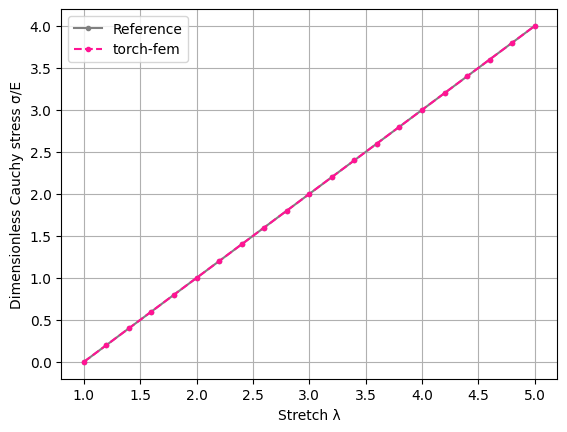

In [3]:
# Create model
material = IsotropicElasticity3D(E=E, nu=nu)
box = Solid(nodes, elements, material)
box.constraints = constraints
box.displacements = displacements

# Solve
u1, f1, σ1, F1, α1 = box.solve(increments=increments, return_intermediate=True)

# Plot
plt.plot(λ, σ1_ref / E, ".-", color="gray", label="Reference")
plt.plot(λ, σ1[..., 0, 0].mean(dim=1) / E, ".--", color="deeppink", label="torch-fem")
plt.xlabel("Stretch λ")
plt.ylabel("Dimensionless Cauchy stress σ/E")
plt.grid()
plt.legend()
plt.show()

## Hencky material

In [4]:
# Reference solution
σ2_ref = torch.log(λ) * E

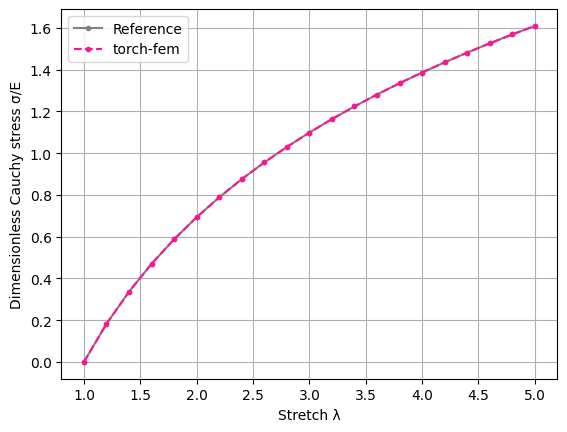

In [5]:
# Create model
material = IsotropicHencky3D(E=E, nu=nu)
box = Solid(nodes, elements, material)
box.constraints = constraints
box.displacements = displacements

# Solve
u2, f2, σ2, F2, α2 = box.solve(
    increments=increments, return_intermediate=True, nlgeom=True
)

plt.plot(λ, σ2_ref / E, ".-", color="gray", label="Reference")
plt.plot(λ, σ2[..., 0, 0].mean(dim=1) / E, ".--", color="deeppink", label="torch-fem")
plt.xlabel("Stretch λ")
plt.ylabel("Dimensionless Cauchy stress σ/E")
plt.grid()
plt.legend()
plt.show()

## Neo-Hookean hyperelasticity 

The strain energy function for this Neo-Hookean material is chosen as 

$$
    \psi(C) = \frac{\mu}{2} \left( \textrm{tr}(C) - 3\right) - \mu \log(J) + \frac{\lambda}{2} \log(J)^2
$$

with the right Cauchy-Green tensor 
$$
    C = F^\top F
$$

and the Jacobian 
$$
    J = \det(F).
$$

In [6]:
# Analytical reference solution
J = fsolve(
    lambda J: mu * (J / λ.numpy() - 1) + lbd * np.log(J),
    x0=np.ones(λ.shape),
    xtol=1e-10,
)
σ3_ref = 1 / J * (lbd * np.log(J) + mu * (λ.numpy() ** 2 - 1))

Increment 1 | Iteration 1 | Residual: 1.56316e+02
Increment 1 | Iteration 2 | Residual: 4.09113e+01
Increment 1 | Iteration 3 | Residual: 1.41948e+01
Increment 1 | Iteration 4 | Residual: 4.83299e+00
Increment 1 | Iteration 5 | Residual: 1.59397e+00
Increment 1 | Iteration 6 | Residual: 5.09940e-01
Increment 1 | Iteration 7 | Residual: 1.61949e-01
Increment 1 | Iteration 8 | Residual: 5.17027e-02
Increment 1 | Iteration 9 | Residual: 1.66642e-02
Increment 1 | Iteration 10 | Residual: 5.42387e-03
Increment 1 | Iteration 11 | Residual: 1.78036e-03
Increment 1 | Iteration 12 | Residual: 5.88343e-04
Increment 1 | Iteration 13 | Residual: 1.95420e-04
Increment 1 | Iteration 14 | Residual: 6.51534e-05
Increment 1 | Iteration 15 | Residual: 2.17813e-05
Increment 1 | Iteration 16 | Residual: 7.29577e-06
Increment 1 | Iteration 17 | Residual: 2.44711e-06
Increment 1 | Iteration 18 | Residual: 8.21594e-07
Increment 2 | Iteration 1 | Residual: 8.73711e+00
Increment 2 | Iteration 2 | Residual: 9.6

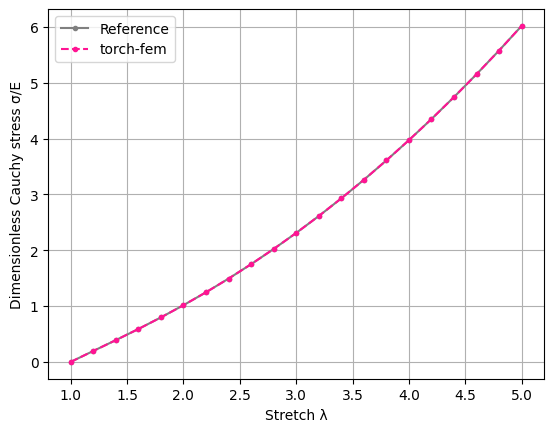

In [7]:
def psi(F):
    """Neo-Hookean strain energy density function."""
    # Compute the right Cauchy-Green deformation tensor
    C = F.transpose(-1, -2) @ F
    # Stable computation of the logarithm of the determinant
    logJ = 0.5 * torch.logdet(C)
    return mu / 2 * (torch.trace(C) - 3.0) - mu * logJ + lbd / 2 * logJ**2


# Create model
material = Hyperelastic3D(psi)

box = Solid(nodes, elements, material)
box.constraints = constraints
box.displacements = displacements

# Solve
u3, f3, σ3, F3, α3 = box.solve(
    increments=increments, return_intermediate=True, nlgeom=True, verbose=True
)
with torch.no_grad():
    plt.plot(λ, σ3_ref / E, ".-", color="gray", label="Reference")
    plt.plot(
        λ,
        σ3[..., 0, 0].mean(dim=1) / E,
        ".--",
        color="deeppink",
        label="torch-fem",
    )
    plt.xlabel("Stretch λ")
    plt.ylabel("Dimensionless Cauchy stress σ/E")
    plt.grid()
    plt.legend()
    plt.show()

## Ogden Hyperelasticity 

In [8]:
def psi(C):
    """Ogden strain energy density function."""
    # Enforce symmetry (needed to ensure symmetric Hessian)
    C = 0.5 * (C + C.transpose(-1, -2))
    # Stable computation of the logarithm of the determinant
    eigvals = torch.linalg.eigvalsh(C)
    lambdas = torch.sqrt(eigvals)
    J = torch.prod(lambdas, dim=-1)
    return (mu / alpha) * (torch.sum(lambdas**alpha) - 3) + 0.5 * lbd * (J - 1) ** 2


# Create model
material = Hyperelastic3D(psi)

box = Solid(nodes, elements, material)
box.constraints = constraints
box.displacements = displacements

# Solve
u4, f4, σ4, F4, α4 = box.solve(
    increments=increments, return_intermediate=True, nlgeom=True, verbose=True
)
with torch.no_grad():
    # plt.plot(λ, σ4_ref / E, ".-", color="gray", label="Reference")
    plt.plot(
        λ,
        σ4[..., 0, 0].mean(dim=1) / E,
        ".--",
        color="deeppink",
        label="torch-fem",
    )
    plt.xlabel("Stretch λ")
    plt.ylabel("Dimensionless Cauchy stress σ/E")
    plt.grid()
    plt.legend()
    plt.show()

Increment 1 | Iteration 1 | Residual: 9.95019e+01


/Users/meyernil/Code/torch-fem/src/torchfem/sparse.py:262: MatrixRankWarning: Matrix is exactly singular
  x_xp = scipy_spsolve(A_np, b_np)


_LinAlgError: linalg.eigh: (Batch element 0): The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 2).

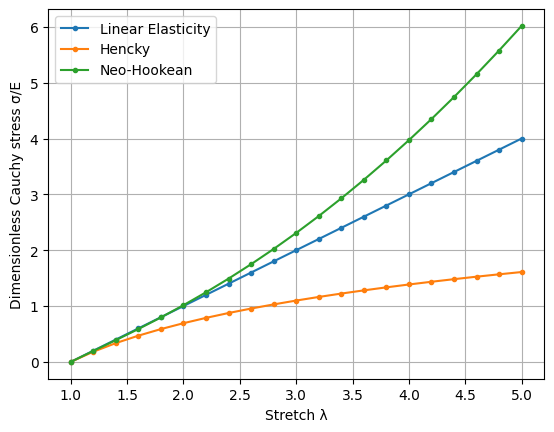

In [ ]:
with torch.no_grad():
    plt.plot(
        F1[..., 0, 0].mean(dim=1),
        σ1[..., 0, 0].mean(dim=1) / E,
        ".-",
        label="Linear Elasticity",
    )
    plt.plot(
        F2[..., 0, 0].mean(dim=1),
        σ2[..., 0, 0].mean(dim=1) / E,
        ".-",
        label="Hencky",
    )
    plt.plot(
        F3[..., 0, 0].mean(dim=1),
        σ3[..., 0, 0].mean(dim=1) / E,
        ".-",
        label="Neo-Hookean",
    )
    plt.xlabel("Stretch λ")
    plt.ylabel("Dimensionless Cauchy stress σ/E")
    plt.grid()
    plt.legend()
    plt.show()